In [90]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.io import imread
import os
import time
import datetime
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.manifold import TSNE

### Build dataloader

In [91]:
class MyoDataSet(Dataset):
    def __init__(self, folder, len_in):     # Images are placed under a single folder; first image name is treatment type
        super().__init__()

        fileList = os.listdir(folder)       # find all images in folder
        self.image_stacks = []
        self.image_size = []
        self.label_list = []
        for ii in range(len(fileList)):
            fpath = folder+'/'+fileList[ii]
            im = imread(fpath).astype('float32')
            self.image_stacks += [torch.Tensor(im)/torch.Tensor(im).max()]
            self.image_size += [im.shape[0]]
            self.label_list += [fileList[ii].split('_')[0]]
        
        self.len_in = len_in
        
    def __len__(self):
        numMovie = len(self.label_list)
        return np.sum(self.image_size) - numMovie * (self.len_in-1)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        eff_img_size = np.array(self.image_size) - (self.len_in - 1)
        cum_img_size = np.cumsum(eff_img_size)
        image_id = np.sum(idx>=cum_img_size)
        stack_id = idx if image_id==0 else idx-cum_img_size[image_id-1]

        image_stack = self.image_stacks[image_id]
        x = {'input': image_stack[stack_id:stack_id+self.len_in], 'target': image_stack[stack_id:stack_id+self.len_in], 'label': self.label_list[image_id]}

        return x
    
    def get_loader(self, indices, batch_size, num_workers, pin_memory=True):
        sampler = SubsetRandomSampler(indices)
        loader = torch.utils.data.DataLoader(self, 
            batch_size=batch_size,
            num_workers=num_workers, # number of cores to use, I usually just choose either 0 or 4
            sampler=sampler, 
            pin_memory=pin_memory) # pin memory should be true if you are transferring data between cpu and gpu
        return loader

In [2]:
class MyoDataSet(Dataset):
    def __init__(self, image_stack, len_in, normalization=1000):
        super().__init__()

        self.data = torch.tensor(image_stack/normalization)
        self.len_in = len_in

    def __len__(self):
        return len(self.data)-self.len_in+1

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = {'input': self.data[idx:idx+self.len_in], 
             'target': self.data[idx:idx+self.len_in]}
        
        return x

    def get_loader(self, indices, batch_size, num_workers, pin_memory=True):
        sampler = SubsetRandomSampler(indices)
        loader = torch.utils.data.DataLoader(self, 
            batch_size=batch_size,
            num_workers=num_workers, # number of cores to use, I usually just choose either 0 or 4
            sampler=sampler, 
            pin_memory=pin_memory) # pin memory should be true if you are transferring data between cpu and gpu
        return loader



In [118]:
trainSet = MyoDataSet('./data', 1)

tensor(0.4220)
tensor(0.5711)
tensor(0.5896)
tensor(0.7706)
tensor(0.5997)


<Figure size 432x576 with 0 Axes>

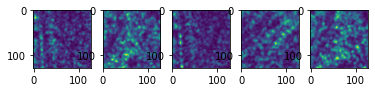

In [120]:
ct = 0
plt.figure(figsize=(6,8))
fig, ax = plt.subplots(1, 5)
for id in np.random.randint(len(trainSet), size = 5):
    x = trainSet[id]
    print(x['input'].max())
    ax[ct].imshow(x['input'].squeeze())
    ct += 1

In [104]:
print(trainSet[50]['label'])

JLY


In [138]:
train_loader = trainSet.get_loader(np.arange(len(trainSet)), 10, 0)
x = next(iter(train_loader))
print(x['target'][0,:].max())
#for thisbatch in train_loader:
#    print(thisbatch['input'].shape)
print(len(train_loader))

tensor(0.8978)
20


### Define convolutional autoencoder

In [122]:
class encoderNN(nn.Module):
    def __init__(self, input_size=(1, 128, 128), fmap_inc_factor = 2, layers=3, downsample_factor=2, neck_dim=100):
        super().__init__()

        in_channel, h, w = tuple(input_size)
        current_size = (h, w)

        # List of encoder layers
        encoderList = []
        current_fmaps = in_channel
        for ii in range(layers):
            out_fmap = current_fmaps * fmap_inc_factor
            encoderList += [nn.Conv2d(current_fmaps, out_fmap, kernel_size=(3,3), padding=1),
                         #nn.BatchNorm2d(out_fmap),
                         nn.ReLU(),
                         nn.MaxPool2d((downsample_factor, downsample_factor))]
            current_fmaps = out_fmap
            h = int(h/downsample_factor)
            w = int(w/downsample_factor)
        
        self.encoder = nn.Sequential(*encoderList)
        self.bottom_h = h
        self.bottom_w = w

        # List of bottleneck layers
        dense1 = current_fmaps*h*w
        neckList = [nn.Flatten(),
                    nn.Linear(dense1, neck_dim),
                    nn.ReLU(),
                    nn.Dropout()]

        self.bottleneck = nn.Sequential(*neckList)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        return x

class interp(nn.Module):
    def __init__(self, size, mode='nearest-exact'):
        super().__init__()

        self.size = size
        self.mode = mode

    def forward(self, x):
        return nn.functional.interpolate(x, size = self.size, mode = self.mode)

class decoderNN(nn.Module):
    def __init__(self, output_size=(1, 128, 128), fmap_dec_factor = 2, layers=3, upsample_factor=2, neck_dim=100):
        super().__init__()

        target_fmaps, h, w = tuple(output_size)
        self.bottom_h = int(h * upsample_factor**(-layers))
        self.bottom_w = int(w * upsample_factor**(-layers))
        self.in_channel = int(target_fmaps * np.power(fmap_dec_factor, layers))

        dense1 = self.in_channel * self.bottom_h * self.bottom_w

        self.upNeck = nn.Sequential(nn.Linear(neck_dim, dense1), nn.ReLU(), nn.Dropout())

        decoderList = []

        current_fmaps = self.in_channel       # Try interpolate+convolution instead of ConvTranspose2d to avoid checkerboard artifect?
        #(h, w) = (self.bottom_h*upsample_factor, self.bottom_w*upsample_factor)
        for ii in range(layers-1):
            out_fmaps = int(current_fmaps / fmap_dec_factor)
            decoderList += [nn.ConvTranspose2d(current_fmaps, out_fmaps, kernel_size = (4,4), stride = upsample_factor, padding = 1), 
                            nn.BatchNorm2d(out_fmaps),
                            nn.ReLU()] #interp((h, w), 'nearest-exact'), nn.Conv2d(current_fmaps, out_fmaps, kernel_size=(3,3), padding=1),
            current_fmaps = out_fmaps
            #(h, w) = (h*upsample_factor, w*upsample_factor)
         
        decoderList += [nn.ConvTranspose2d(current_fmaps, target_fmaps, kernel_size = (4,4), stride = upsample_factor, padding = 1)] #interp((h, w), 'nearest-exact'), nn.Conv2d(current_fmaps, target_fmaps, kernel_size=(3,3), padding=1)
                        #nn.BatchNorm2d(target_fmaps),
                        #nn.Sigmoid()]
                        
        self.decoder = nn.Sequential(*decoderList)

    def forward(self, x):
        x = self.upNeck(x)
        x = x.view(-1, self.in_channel, self.bottom_h, self.bottom_w)
        x = self.decoder(x)
        return x


class CAE(nn.Module):
    def __init__(self, input_size = (1, 128, 128), fmap_inc_factor = 2, layers = 3, sample_factor = 2, neckdim = 100):
        super().__init__()
        self.input_size = input_size
        self.fmap_inc_factor = fmap_inc_factor
        self.layers = layers
        self.sample_factor = sample_factor
        self.neckdim = neckdim

        self.encoding = encoderNN(self.input_size, self.fmap_inc_factor, self.layers, self.sample_factor, self.neckdim)
        self.decoding = decoderNN(self.input_size, self.fmap_inc_factor, self.layers, self.sample_factor, self.neckdim)
        
    def forward(self, x):
        encoded = self.encoding(x)
        decoded = self.decoding(encoded)
        return decoded

In [147]:
# Print model summary
input_size = (1, 128, 128)
fmap_inc_factor = 2
layers = 2
sample_factor = 2
neckdim = 100
model = CAE(input_size, fmap_inc_factor, layers, sample_factor, neckdim)
summary(model, input_size=(10, 1, 128, 128))       # Input size for torchinfo needs to have the size (B,C,H,W)

Layer (type:depth-idx)                   Output Shape              Param #
CAE                                      [10, 1, 128, 128]         --
├─encoderNN: 1-1                         [10, 100]                 --
│    └─Sequential: 2-1                   [10, 4, 32, 32]           --
│    │    └─Conv2d: 3-1                  [10, 2, 128, 128]         20
│    │    └─ReLU: 3-2                    [10, 2, 128, 128]         --
│    │    └─MaxPool2d: 3-3               [10, 2, 64, 64]           --
│    │    └─Conv2d: 3-4                  [10, 4, 64, 64]           76
│    │    └─ReLU: 3-5                    [10, 4, 64, 64]           --
│    │    └─MaxPool2d: 3-6               [10, 4, 32, 32]           --
│    └─Sequential: 2-2                   [10, 100]                 --
│    │    └─Flatten: 3-7                 [10, 4096]                --
│    │    └─Linear: 3-8                  [10, 100]                 409,700
│    │    └─ReLU: 3-9                    [10, 100]                 --
│    │    

### Define model training/validation

In [148]:
if not os.path.exists('./logs'):
    os.mkdir('./logs')
%load_ext tensorboard
%tensorboard --logdir ./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [149]:
## To do: move to device, metric for validation? training rate scheduler?

def train(model, dataloader, lossfn, optimizer, epochNum, tb_logger):     # Training step for each epoch
    model.train()

    totalLoss = 0
    optimizer.zero_grad()
    for minibatch in dataloader:
        y = model(minibatch['input'])
        loss = lossfn(y, minibatch['target'])
        loss.backward()
        optimizer.step()
        totalLoss += loss

    if tb_logger is not None:
        tb_logger.add_scalar(tag="train_loss", scalar_value=totalLoss.item(), global_step=epochNum)

    return totalLoss

def validate(model, dataloader, lossfn, epochNum, tb_logger):      # Validate after each epoch, returns the loss 
    model.eval()

    x = next(iter(dataloader))
    y = model(x['input'])
    loss = lossfn(y, x['target'])

    if tb_logger is not None:
        tb_logger.add_scalar(tag="val_loss", scalar_value=loss.item(), global_step=epochNum)

    return loss

In [150]:
loss = torch.nn.L1Loss()
optim = torch.optim.Adam(params = model.parameters(), lr = 1e-4)
#timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H:%M:%S')
logger = SummaryWriter('./logs/mixed_train')

numEpoch = 500
train_loss = np.zeros(numEpoch)
val_loss = np.zeros(numEpoch)
for ii in tqdm(range(numEpoch)):
    epochLoss = train(model, train_loader, loss, optim, ii, logger)
    validLoss = validate(model, train_loader, loss, ii, logger)
    train_loss[ii] = epochLoss
    val_loss[ii] = validLoss
    if ii%50==1:
        print("Epoch ", ii, "    Training loss: ", epochLoss.detach().cpu().numpy(), ", Validation loss: ", validLoss.detach().cpu().numpy())

#torch.save(model.state_dict(), 'CAE_2layer_mixed.pt')
    

  0%|          | 2/500 [00:00<03:09,  2.62it/s]

Epoch  1     Training loss:  5.019477 , Validation loss:  0.20777476


 10%|█         | 52/500 [00:17<02:30,  2.97it/s]

Epoch  51     Training loss:  1.5851789 , Validation loss:  0.07015564


 20%|██        | 102/500 [00:34<02:15,  2.95it/s]

Epoch  101     Training loss:  1.3185636 , Validation loss:  0.0713485


 30%|███       | 152/500 [00:51<01:50,  3.14it/s]

Epoch  151     Training loss:  1.1698692 , Validation loss:  0.054717936


 40%|████      | 202/500 [01:07<01:38,  3.03it/s]

Epoch  201     Training loss:  1.0899014 , Validation loss:  0.055778842


 50%|█████     | 252/500 [01:24<01:18,  3.15it/s]

Epoch  251     Training loss:  1.0638468 , Validation loss:  0.054294296


 60%|██████    | 302/500 [01:40<01:05,  3.03it/s]

Epoch  301     Training loss:  1.0358211 , Validation loss:  0.044674393


 70%|███████   | 352/500 [01:56<00:45,  3.24it/s]

Epoch  351     Training loss:  1.0243857 , Validation loss:  0.042431813


 80%|████████  | 402/500 [02:12<00:31,  3.14it/s]

Epoch  401     Training loss:  1.0234574 , Validation loss:  0.048992917


 90%|█████████ | 452/500 [02:28<00:15,  3.14it/s]

Epoch  451     Training loss:  1.0118377 , Validation loss:  0.041880347


100%|██████████| 500/500 [02:44<00:00,  3.04it/s]


### Examine model output

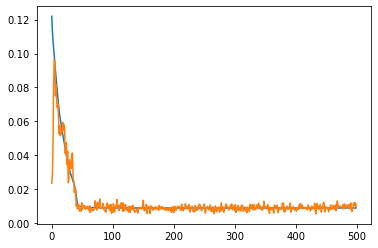

In [97]:
plt.plot(np.arange(500), train_loss)
plt.plot(np.arange(500), val_loss)

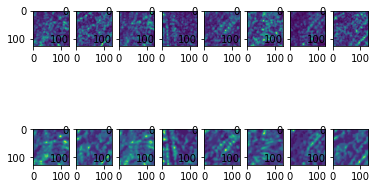

In [151]:
model.eval()
testSet = MyoDataSet('./data', 1)
testloader = testSet.get_loader(np.arange(len(testSet)), 8, 0)

fig, ax = plt.subplots(2, 8)
ct = 0
batch = next(iter(testloader))
x = batch['input']
y = batch['target']
pred = model(x)
for jj in range(len(x)):
    ax[0][ct].imshow(y[jj, ...].squeeze().detach().cpu().numpy())
    ax[1][ct].imshow(pred[jj, ...].squeeze().detach().cpu().numpy())
    ct += 1

### T-SNE of bottleneck

torch.Size([20, 1, 128, 128])


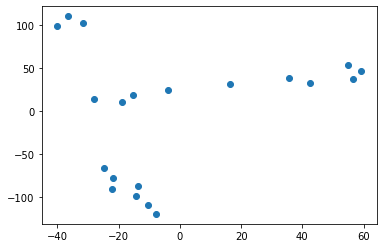

In [133]:
model.eval()
test_loader = trainSet.get_loader(np.arange(len(trainSet)), 20, 0)
X_in = next(iter(test_loader))
print(X_in['input'].shape)
X = model.encoding(X_in['input']).detach()
X = torch.flatten(X, start_dim = 1)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
color = {'JLY': 'red', 'WT': 'blue'}
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
# Plot bottleneck layers
#fig, ax = plt.subplots(1, 4)
#for jj in range(len(x)):
#    ax[jj].imshow(X[jj, 3, ...].squeeze().detach().cpu().numpy())